# Crowd Counting Dataset Preprocessing
The notebook contains the full preprocessing pipeline used to generate density maps, visualizations, and CSV reports for Part A and Part B.

In [18]:
import os
import numpy as np
import scipy.io as sio
from PIL import Image
from scipy.ndimage import gaussian_filter
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import csv

In [19]:
SIGMA = 15

DATASETS = [
    "data/part_A_final/train_data",
    "data/part_B_final/train_data"
]

In [20]:
def generate_density_map(img_path, gt_path):
    img = np.array(Image.open(img_path))
    h, w = img.shape[:2]
    mat = sio.loadmat(gt_path)
    points = mat["image_info"][0][0][0][0][0]
    density = np.zeros((h, w), dtype=np.float32)
    for p in points:
        x, y = int(p[0]), int(p[1])
        if x < w and y < h:
            density[y, x] = 1
    density = gaussian_filter(density, sigma=SIGMA)
    return density, points

In [21]:
def save_visual(img_path, density_map, points, save_path):
    img = np.array(Image.open(img_path))

    gt_count = len(points)
    pred_count = density_map.sum()

    plt.figure(figsize=(22, 8), dpi=180)

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(f"Original Image\nGT Count = {gt_count}", fontsize=14)
    plt.axis("off")

    # GT Points
    plt.subplot(1, 3, 2)
    plt.imshow(img)
    plt.scatter(points[:,0], points[:,1], s=8, c='red')
    plt.title("Ground Truth Points", fontsize=14)
    plt.axis("off")

    # Density Map
    plt.subplot(1, 3, 3)
    plt.imshow(density_map, cmap='jet')
    plt.title(f"Density Map\nPredicted Count = {pred_count:.1f}", fontsize=14)
    plt.axis("off")

    plt.tight_layout()
    plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.close()


In [22]:
def append_csv_row(csv_path, row):
    write_header = not csv_path.exists()
    with open(csv_path, 'a', newline='') as f:
        writer = csv.writer(f)
        if write_header:
            writer.writerow(["Image Name", "GT Count", "Predicted Count", "Absolute Error", "Dataset"])
        writer.writerow(row)

In [23]:
def process_folder(base_dir):
    base_dir = Path(base_dir)
    img_dir = base_dir / "images"
    gt_dir = base_dir / "ground_truth"
    dm_dir = base_dir / "density_maps"
    vis_dir = base_dir / "visualizations"
    report_path = base_dir / "report.csv"

    dm_dir.mkdir(exist_ok=True)
    vis_dir.mkdir(exist_ok=True)

    img_files = list(img_dir.glob("*.jpg"))
    print(f"Processing Dataset: {base_dir}, Total Images: {len(img_files)}")

    for img_path in tqdm(img_files):
        img_name = img_path.stem
        gt_path = gt_dir / f"GT_{img_name}.mat"
        if not gt_path.exists():
            print(f"Missing GT for {img_path.name}")
            continue

        density_map, points = generate_density_map(img_path, gt_path)
        np.save(dm_dir / f"{img_name}.npy", density_map)

        save_visual(img_path, density_map, points, vis_dir / f"{img_name}_viz.png")

        gt_count = len(points)
        pred_count = float(density_map.sum())
        abs_error = abs(gt_count - pred_count)

        append_csv_row(report_path, [img_name, gt_count, pred_count, abs_error, base_dir.name])

    print(f"Completed: {base_dir}")

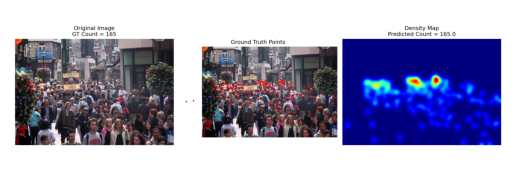

In [24]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("data/part_A_final/train_data/visualizations/IMG_67_viz.png")
plt.imshow(img)
plt.axis("off")
plt.show()
